In [17]:
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.regularizers import l2
from sklearn import metrics

import tensorflow as tf
import tensorflow.keras as keras
from tensorboard.plugins.hparams import api as hp

physical_devices = tf.config.list_physical_devices()
%load_ext tensorboard
print(physical_devices)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


In [5]:
class_names = ['buildings', 'forest', 'glacier', 'mountain',
               'sea', 'street']
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

train_count = []
for c in class_names:
    print("Total training images for", c, ":", len(os.listdir(train_dir + "/" + c)))
    train_count.append(len(os.listdir(train_dir + "/" + c)))

print("")
test_count = []
for c in class_names:
    print("Total testing images for", c, ":", len(os.listdir(test_dir + "/" + c)))
    test_count.append(len(os.listdir(test_dir + "/" + c)))
print('')
for i in range(len(train_count)):
    tot = train_count[i] + test_count[i]
    print("Percentage training for", class_names[i], ":", train_count[i]/tot)
    print('Total images for', class_names[i], ':', train_count[i] + test_count[i])
    print('')
    
print('Total training images:', sum(train_count))
print('Total testing images:', sum(test_count))

Total training images for buildings : 2191
Total training images for forest : 2271
Total training images for glacier : 2404
Total training images for mountain : 2512
Total training images for sea : 2274
Total training images for street : 2382

Total testing images for buildings : 437
Total testing images for forest : 474
Total testing images for glacier : 553
Total testing images for mountain : 525
Total testing images for sea : 510
Total testing images for street : 501

Percentage training for buildings : 0.8337138508371386
Total images for buildings : 2628

Percentage training for forest : 0.8273224043715847
Total images for forest : 2745

Percentage training for glacier : 0.8129861345958742
Total images for glacier : 2957

Percentage training for mountain : 0.8271320381955878
Total images for mountain : 3037

Percentage training for sea : 0.8168103448275862
Total images for sea : 2784

Percentage training for street : 0.826222684703434
Total images for street : 2883

Total training 

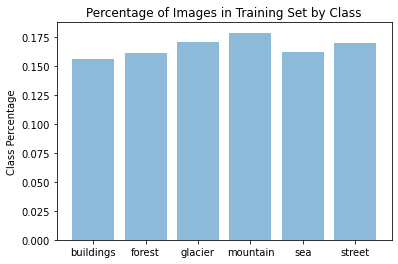

In [6]:
train_perc = [x / sum(train_count)for x in train_count]
y_pos = np.arange(len(class_names))

plt.bar(y_pos, train_perc, align='center', alpha=0.5)
plt.xticks(y_pos, class_names)
plt.ylabel('Class Percentage')
plt.title('Percentage of Images in Training Set by Class')

plt.show()

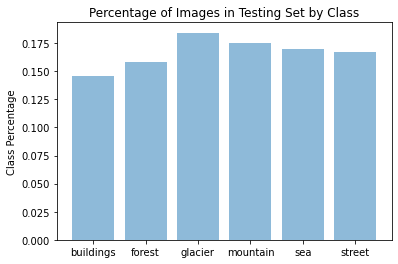

In [7]:
test_perc = [x / sum(test_count)for x in test_count]
y_pos = np.arange(len(class_names))

plt.bar(y_pos, test_perc, align='center', alpha=0.5)
plt.xticks(y_pos, class_names)
plt.ylabel('Class Percentage')
plt.title('Percentage of Images in Testing Set by Class')

plt.show()

In [8]:
# get training data
image_sizes = {}
image_types = {}
for index, c in enumerate(class_names):
    for dr in os.listdir(train_dir + "/" + c):
        im = Image.open(train_dir + "/" + c + "/" + dr)
        if str(im.size) in image_sizes.keys():
            image_sizes[str(im.size)] = image_sizes[str(im.size)] + 1
        else:
            image_sizes[str(im.size)] = 1
        if str(im.mode) in image_types.keys():
            image_types[str(im.mode)] = image_types[str(im.mode)] + 1
        else:
            image_types[str(im.mode)] = 1
len(image_sizes)

31

In [9]:
print(image_sizes)
print("\n")
print(image_types)
# looking at this, we can tell that almost all images are 150x150 so that shall be the size of the image
IMAGE_HEIGHT = 227
IMAGE_WIDTH = 227

k = Counter(image_sizes)
  
# Finding 3 highest values
high = k.most_common(3) 

print("\n3 highest values in image sizes")
  
for i in high:
    print(i[0]," :",i[1]," ")

{'(150, 150)': 13986, '(150, 124)': 1, '(150, 113)': 7, '(150, 108)': 2, '(150, 133)': 1, '(150, 115)': 1, '(150, 135)': 3, '(150, 136)': 2, '(150, 110)': 1, '(150, 105)': 1, '(150, 111)': 3, '(150, 120)': 1, '(150, 149)': 1, '(150, 143)': 2, '(150, 146)': 2, '(150, 134)': 2, '(150, 142)': 2, '(150, 123)': 2, '(150, 119)': 1, '(150, 102)': 1, '(150, 76)': 1, '(150, 97)': 1, '(150, 144)': 2, '(150, 103)': 1, '(150, 100)': 1, '(150, 141)': 1, '(150, 145)': 1, '(150, 81)': 1, '(150, 147)': 1, '(150, 131)': 1, '(150, 140)': 1}


{'RGB': 14034}

3 highest values in image sizes
(150, 150)  : 13986  
(150, 113)  : 7  
(150, 135)  : 3  


In [10]:
# create generators for getting data
training_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)
training_generator = training_datagen.flow_from_directory(train_dir,
                            target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=20, class_mode="categorical")
testing_generator = testing_datagen.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                            batch_size=20, class_mode="categorical")

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [12]:
def buildNet(net, drop_rate):
    regularizer = l2(0.001)
    
    net.add(keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                                activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding="same", ))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    
    net.add(keras.layers.Flatten())
    net.add(keras.layers.Dense(4096, activation='relu'))
    net.add(keras.layers.Dropout(drop_rate))
    net.add(keras.layers.Dense(4096, activation='relu'))
    net.add(keras.layers.Dropout(drop_rate))
    net.add(keras.layers.Dense(6, activation='softmax'))
    
    return net

def buildNetHyper(net, hparams):
    net.add(keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                                activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))
    net.add(keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1),
                                activation='relu', padding="same"))
    net.add(keras.layers.BatchNormalization())
    net.add(keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    
    net.add(keras.layers.Flatten())
    net.add(keras.layers.Dense(4096, activation='relu'))
    net.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    net.add(keras.layers.Dense(4096, activation='relu'))
    net.add(keras.layers.Dropout(hparams[HP_DROPOUT]))
    net.add(keras.layers.Dense(6, activation='softmax'))
    
    return net

In [21]:
drop_rate = 0.4
keras.backend.clear_session()
model = tf.keras.Sequential()

model = buildNet(model, drop_rate)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', 
              metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
average_pooling2d (AveragePo (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
average_pooling2d_1 (Average (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [22]:
# train the model
history = model.fit(training_generator,
                    epochs=15,
                   validation_data=testing_generator,
                   shuffle=False)

Epoch 1/15
702/702 [==============================] - 32s 46ms/step - loss: 1.0125 - acc: 0.6103 - precision: 0.7039 - recall: 0.4952 - val_loss: 0.9854 - val_acc: 0.6337 - val_precision: 0.7468 - val_recall: 0.4720
Epoch 2/15
702/702 [==============================] - 32s 46ms/step - loss: 0.8117 - acc: 0.6994 - precision: 0.7606 - recall: 0.6198 - val_loss: 0.9325 - val_acc: 0.6603 - val_precision: 0.7637 - val_recall: 0.5323
Epoch 3/15
702/702 [==============================] - 33s 48ms/step - loss: 0.7228 - acc: 0.7374 - precision: 0.7865 - recall: 0.6728 - val_loss: 1.1578 - val_acc: 0.5837 - val_precision: 0.6562 - val_recall: 0.5237
Epoch 4/15
702/702 [==============================] - 33s 47ms/step - loss: 0.6473 - acc: 0.7619 - precision: 0.8082 - recall: 0.7137 - val_loss: 1.0135 - val_acc: 0.6310 - val_precision: 0.7417 - val_recall: 0.5340
Epoch 5/15
702/702 [==============================] - 37s 52ms/step - loss: 0.5902 - acc: 0.7855 - precision: 0.8221 - recall: 0.7438 - 

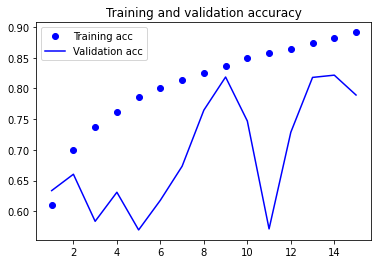

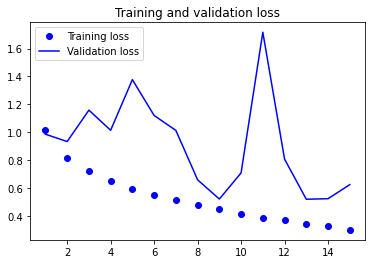

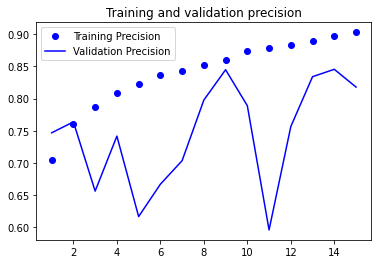

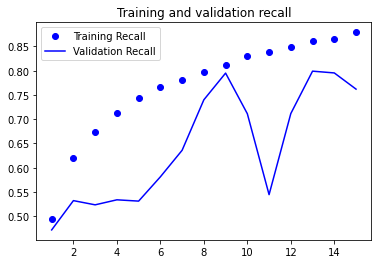

In [23]:
# graph post training data for validation and training against eachother
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
prec = history.history['precision']
val_prec = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
epochs = range(1, len(acc) + 1)

# accuracy graph
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# loss graph
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# precision graph
plt.plot(epochs, prec, 'bo', label='Training Precision')
plt.plot(epochs, val_prec, 'b', label='Validation Precision')
plt.title('Training and validation precision')
plt.legend()
plt.show()

# recall graph
plt.plot(epochs, recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation recall')
plt.legend()
plt.show()

In [20]:
# review model with seperate validation function for categorical info
predictions = model.predict(testing_generator)
predicted_classes = np.argmax(predictions, axis=1)
classes = testing_generator.classes
report = metrics.classification_report(classes, predicted_classes, zero_division=False)
print(report)

              precision    recall  f1-score   support

           0       0.17      0.25      0.20       437
           1       0.17      0.16      0.16       474
           2       0.18      0.13      0.15       553
           3       0.18      0.12      0.15       525
           4       0.17      0.24      0.20       510
           5       0.13      0.12      0.12       501

    accuracy                           0.17      3000
   macro avg       0.17      0.17      0.16      3000
weighted avg       0.17      0.17      0.16      3000



In [ ]:
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.0, 0.2, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )


In [ ]:
def train_test_model(hparams):
    keras.backend.clear_session()
    model = tf.keras.Sequential()

    model = buildNetHyper(model, hparams)

    model.compile(optimizer=hparams[HP_OPTIMIZER], loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    model.fit(training_generator, epochs=20)
    _, accuracy = model.evaluate(testing_generator)
    return accuracy

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [ ]:
session_num = 0

for dropout_rate in HP_DROPOUT.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
            HP_DROPOUT: dropout_rate,
            HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1


In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [3]:
# optmial, drop=0.4 optimizer=adam
np.around([[0.2], [0.6]])

array([[0.],
       [1.]])

In [ ]:
# save model for further training
model.save("models/")